# **Capstone Project: Providing data-driven suggestions for HR**

### Objective

The HR team at Salifort Motors is keen on enhancing employee satisfaction within the company. They've gathered data from the employees, but now they're unsure about how to use it. They've reached out to me, a data analytics professional, to provide insights based on the collected data. Specifically, they want to know what factors might lead an employee to leave the company.

In this project, my main objectives are to analyze the HR data and develop a model that can predict whether an employee is likely to leave the company. If we can identify employees who are likely to quit, we may uncover the reasons behind their departure. This is valuable because the process of finding, interviewing, and hiring new employees is both time-consuming and costly. By improving employee retention, we aim to benefit the company in terms of time and resources.

### Data: [Kaggle](https://www.kaggle.com/datasets/mfaisalqureshi/hr-analytics-and-job-prediction?select=HR_comma_sep.csv)

Variable  |Description |
-----|-----|
satisfaction_level|Employee-reported job satisfaction level [0&ndash;1]|
last_evaluation|Score of employee's last performance review [0&ndash;1]|
number_project|Number of projects employee contributes to|
average_monthly_hours|Average number of hours employee worked per month|
time_spend_company|How long the employee has been with the company (years)
Work_accident|Whether or not the employee experienced an accident while at work
left|Whether or not the employee left the company
promotion_last_5years|Whether or not the employee was promoted in the last 5 years
Department|The employee's department
salary|The employee's salary (U.S. dollars)

In [1]:
import numpy as np
import pandas as pd

# Data Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical Libraries
import scipy.stats as stats

# Statsmodels for statistical modeling
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Scikit-learn for machine learning tasks
from sklearn.utils import resample
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve, auc

## Initial EDA

In [2]:
# Loading dataset into a dataframe
df0 = pd.read_csv("HR_capstone_dataset.csv")

# Displaying the first few rows of the dataframe
df0.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [3]:
# Gathering basic information about the data
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [4]:
# Displaying the data types of each column in the dataframe
df0.dtypes

satisfaction_level       float64
last_evaluation          float64
number_project             int64
average_montly_hours       int64
time_spend_company         int64
Work_accident              int64
left                       int64
promotion_last_5years      int64
Department                object
salary                    object
dtype: object

In [5]:
# Generating descriptive statistics for the dataframe
df0.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


## Data Cleaning

In [6]:
# Displaying the column names of the dataframe
df0.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'Department', 'salary'],
      dtype='object')

In [7]:
# Standardizing the column names to snake_case
df0.columns = df0.columns.str.lower()

In [8]:
# Renaming columns for clarity and consistency
df0.rename(columns = {"average_montly_hours": "average_monthly_hours"}, inplace = True)
df0.rename(columns = {"left": "churned"}, inplace = True)
df0.rename(columns = {"time_spend_company": "years_at_company"}, inplace = True)
df0.rename(columns = {"number_project": "number_of_projects"}, inplace = True)

# Display all column names after the update
df0.columns

Index(['satisfaction_level', 'last_evaluation', 'number_of_projects',
       'average_monthly_hours', 'years_at_company', 'work_accident', 'churned',
       'promotion_last_5years', 'department', 'salary'],
      dtype='object')

In [9]:
# Checking for missing values in each column
df0.isnull().sum()

satisfaction_level       0
last_evaluation          0
number_of_projects       0
average_monthly_hours    0
years_at_company         0
work_accident            0
churned                  0
promotion_last_5years    0
department               0
salary                   0
dtype: int64

In [10]:
# Checking for duplicate rows in the dataframe
df0.duplicated().value_counts()

False    11991
True      3008
dtype: int64

In [11]:
# Inspecting some rows containing duplicates
df0[df0.duplicated()].head()

,satisfaction_level,last_evaluation,number_of_projects,average_monthly_hours,years_at_company,work_accident,churned,promotion_last_5years,department,salary
396,0.46,0.57,2,139,3,0,1,0,sales,low
866,0.41,0.46,2,128,3,0,1,0,accounting,low
1317,0.37,0.51,2,127,3,0,1,0,sales,medium
1368,0.41,0.52,2,132,3,0,1,0,RandD,low
1461,0.42,0.53,2,142,3,0,1,0,sales,low


In [12]:
# Dropping duplicate rows and saving the resulting dataframe in a new variable
df = df0.drop_duplicates()
data = df.copy()

# Displaying the first few rows of the new dataframe
df.head()

,satisfaction_level,last_evaluation,number_of_projects,average_monthly_hours,years_at_company,work_accident,churned,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [13]:
# Counting the occurrences of each unique value in the "department" column
df["department"].value_counts()

sales          3239
technical      2244
support        1821
IT              976
RandD           694
product_mng     686
marketing       673
accounting      621
hr              601
management      436
Name: department, dtype: int64

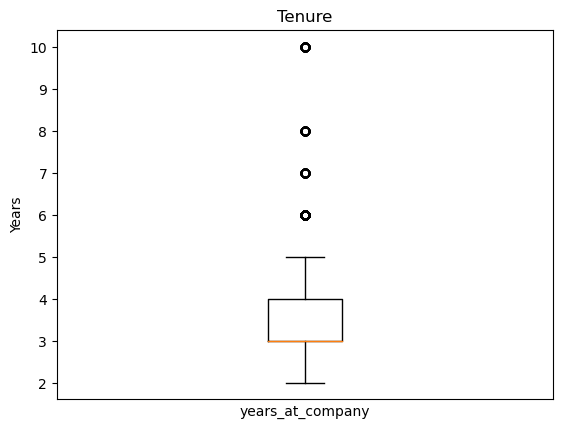

In [14]:
# Creating a boxplot to visualize the distribution of 'tenure' and detect outliers
plt.boxplot(df["years_at_company"])
# Adding title and axis labels for clarity
plt.title("Tenure")
plt.xlabel("years_at_company")
plt.ylabel("Years")
# Removing x-axis ticks for better visualization of the boxplot
plt.xticks([])
# Displaying the boxplot
plt.show()

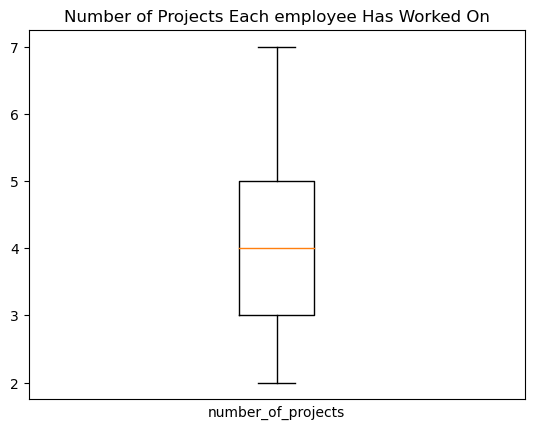

In [15]:
# Creating a boxplot to visualize the distribution of the number of projects each employee has worked on
plt.boxplot(df["number_of_projects"])
# Adding title and axis labels for clarity
plt.title("Number of Projects Each employee Has Worked On")
plt.xlabel("number_of_projects")
# Removing x-axis ticks for better visualization of the boxplot
plt.xticks([])
# Displaying the boxplot
plt.show()

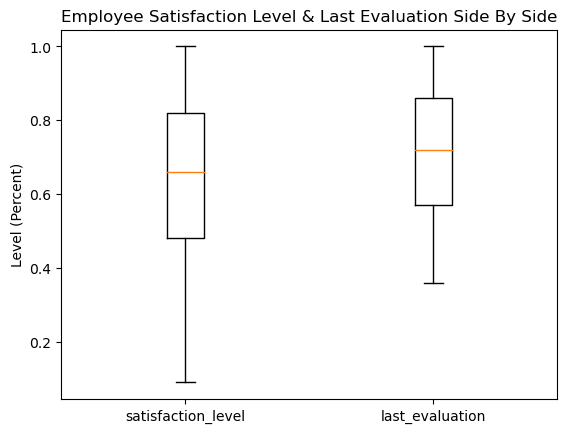

In [16]:
# Creating a side-by-side boxplot to depict employee satisfaction and performance (last evaluation)
fig, ax = plt.subplots()

# Using plt.boxplot() to plot both 'satisfaction_level' and 'last_evaluation' on the same figure
plt.boxplot([df["satisfaction_level"], df["last_evaluation"]], labels = ["satisfaction_level", "last_evaluation"])

# Adding title and axis labels for clarity
plt.title("Employee Satisfaction Level & Last Evaluation Side By Side")
plt.ylabel("Level (Percent)")
# Displaying the side-by-side boxplot
plt.show()

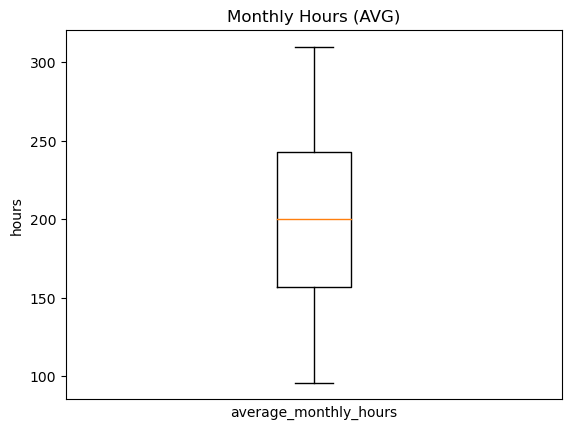

In [17]:
# Creating a boxplot to show the distribution of average monthly hours worked by each employee
plt.boxplot(df["average_monthly_hours"])

# Adding title and axis labels for clarity
plt.title("Monthly Hours (AVG)")
plt.xlabel("average_monthly_hours")
plt.ylabel("hours")

# Removing x-axis ticks for better visualization of the boxplot
plt.xticks([])

# Displaying the boxplot
plt.show()

In [18]:
def outlier_bounds(series):
    """
    Calculates the upper and lower bounds beyond which values would be considered outliers.
    
    Args:
        series: A Pandas Series with numerical values.
    Returns:
        A tuple (lower, upper) representing the lower and upper bounds.
    """
    # Calculate the first and third quartiles
    q1 = np.quantile(series, 0.25)
    q3 = np.quantile(series, 0.75)
    
    # Calculate the interquartile range (IQR)
    iqr = q3 - q1
    
    # Calculate the lower and upper bounds for outliers
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    
    return lower_bound, upper_bound

In [19]:
# Calculating the upper and lower bounds for outliers in the 'years_at_company' feature
lower, upper = outlier_bounds(df["years_at_company"])

In [20]:
# Counting the number of rows outside the upper and lower outlier bounds for 'years_at_company'
outliers_mask = (df["years_at_company"] >= upper) | (df["years_at_company"] <= lower)
df["years_at_company"][outliers_mask].count()

824

In [21]:
# Getting the number of people who churned vs. stayed
left_value_counts = df["churned"].value_counts()

# Calculating the percentage of employees who have left the company
print(f'{left_value_counts[1]/len(df):.2%} of employees have left the company')

16.60% of employees have left the company


In [22]:
# Calculating VIF for each explanatory variable
df_cleaned = df[outliers_mask].copy()

## Feature Engineering

In [23]:
# One-Hot Label encoding the 'salary' and 'department' features
df_encoded = pd.get_dummies(df_cleaned, columns=["department", "salary"], drop_first=True)

# Extracting the explanatory variables (X_data) by excluding the target variable ('churned')
X_data = df_encoded.drop("churned", axis = 1)

In [24]:
# Displaying the columns of the encoded dataframe
df_encoded.columns

Index(['satisfaction_level', 'last_evaluation', 'number_of_projects',
       'average_monthly_hours', 'years_at_company', 'work_accident', 'churned',
       'promotion_last_5years', 'department_RandD', 'department_accounting',
       'department_hr', 'department_management', 'department_marketing',
       'department_product_mng', 'department_sales', 'department_support',
       'department_technical', 'salary_low', 'salary_medium'],
      dtype='object')

In [25]:
# Calculating VIF for each explanatory variable
vif = pd.DataFrame()

# Using variance_inflation_factor to calculate VIF for each variable
vif['VIF'] = [variance_inflation_factor(X_data.values, i) for i in range(X_data.shape[1])]

# Assigning variable names to the VIF dataframe
vif['variable'] = X_data.columns 

In [26]:
# Checking for multicollinearity between the data's features
vif.sort_values("VIF", ascending = False)

,VIF,variable
4,19.137845,years_at_company
1,18.545559,last_evaluation
3,17.163032,average_monthly_hours
2,12.883870,number_of_projects
0,6.507957,satisfaction_level
17,5.364666,salary_medium
13,4.548971,department_sales
16,4.503485,salary_low
15,2.854962,department_technical
10,2.605076,department_management


In [27]:
# Setting the VIF cutoff to determine the amount of multicollinearity allowed amoust the features
vif_cutoff = 20  # Change cutoff to the desired number (e.g., 10, 5, etc.). A smaller number indicates less multicollinearity between features.

# Filtering variables with VIF less than the cutoff
vif_less_than_cutoff = vif[vif["VIF"] < vif_cutoff]

In [28]:
# Extracting feature columns with VIF less than cutoff
feature_columns = list(vif_less_than_cutoff["variable"].values)

In [29]:
# Extracting features using the selected columns with VIF less than cutoff
X = df_encoded.copy().drop(["churned"], axis=1).loc[outliers_mask, feature_columns]

# Response Variable
y = df_encoded.copy()["churned"][outliers_mask]

In [30]:
# Displaying the data types of independent variables
X.dtypes

satisfaction_level        float64
last_evaluation           float64
number_of_projects          int64
average_monthly_hours       int64
years_at_company            int64
work_accident               int64
promotion_last_5years       int64
department_RandD            uint8
department_accounting       uint8
department_hr               uint8
department_management       uint8
department_marketing        uint8
department_product_mng      uint8
department_sales            uint8
department_support          uint8
department_technical        uint8
salary_low                  uint8
salary_medium               uint8
dtype: object

In [31]:
# Displaying the first few rows of independent variables
X.head()

,satisfaction_level,last_evaluation,number_of_projects,average_monthly_hours,years_at_company,work_accident,promotion_last_5years,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,salary_low,salary_medium
1,0.80,0.86,5,262,6,0,0,0,0,0,0,0,0,1,0,0,0,1
17,0.78,0.99,4,255,6,0,0,0,0,0,0,0,0,1,0,0,1,0
34,0.84,0.87,4,246,6,0,0,0,0,1,0,0,0,0,0,0,1,0
47,0.57,0.70,3,273,6,0,0,0,0,0,0,0,0,0,1,0,1,0
67,0.90,0.98,4,264,6,0,0,0,0,0,0,0,1,0,0,0,0,1


## Modeling

In [32]:
# Splitting data into training and test sets for modeling
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size= .2, stratify = y, random_state = 42)

# Splitting data for validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

### Model 1: Logistic Regression with Saga Solver and Elastic Net Penalty 
#### Gridsearch For Best l1 ratio

In [33]:
# Logistic Regression
l1_ratio_logreg = LogisticRegression(
    random_state=42,            # Setting a random seed for reproducibility
    solver='saga',              # Specifying the solver for logistic regression
    max_iter=10000,              # Maximum number of iterations for convergence
    l1_ratio=0.1,                # L1 ratio for elastic net regularization
    class_weight='balanced',     # Balancing class weights to handle imbalanced data
    penalty='elasticnet'         # Elastic net regularization combining L1 and L2 penalties
)

In [34]:
%%time
# Defining the parameter grid to search
param_grid = {'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]}
param_grid = {'l1_ratio': [0.01, 0.03, 0.05, 0.07, 0.09]} 

# Creating a GridSearchCV object
l1_ratio_grid_search = GridSearchCV(
    estimator=l1_ratio_logreg,   # Using the Logistic Regression pipeline as the estimator
    param_grid=param_grid,       # Specifying the parameter grid to search
    cv=5,                        # Number of cross-validation folds
    scoring='recall'             # Using recall as the scoring metric for evaluation
)

# Fitting the model with different l1_ratio values
l1_ratio_grid_search_model = l1_ratio_grid_search.fit(X_train, y_train)

CPU times: user 10.6 s, sys: 81.5 ms, total: 10.7 s
Wall time: 9.84 s


In [35]:
# Printing the best parameters and corresponding score
print("Best l1_ratio:", l1_ratio_grid_search_model.best_params_)
print("Best cross-validation score:", l1_ratio_grid_search_model.best_score_)

# Evaluating the model on the test set with the best parameters
best_model = l1_ratio_grid_search_model.best_estimator_
test_score = best_model.score(X_test, y_test)
print("Test set accuracy with best parameters:", test_score)

Best l1_ratio: {'l1_ratio': 0.01}
Best cross-validation score: 0.9384615384615385
Test set accuracy with best parameters: 0.8545454545454545


In [36]:
# Making predictions on the test set using the best model obtained from grid search
grid_search_y_pred = l1_ratio_grid_search_model.predict(X_test)

In [37]:
# Generating a classification report for model evaluation
pd.DataFrame(classification_report(y_test, grid_search_y_pred, output_dict = True))

,0,1,accuracy,macro avg,weighted avg
precision,0.991736,0.477273,0.854545,0.734504,0.923140
recall,0.839161,0.954545,0.854545,0.896853,0.854545
f1-score,0.909091,0.636364,0.854545,0.772727,0.872727
support,143.000000,22.000000,0.854545,165.000000,165.000000


### Model 2: Logistic Regression with L2 Penalty 
#### Grid Search For The Best Solver

In [38]:
# Logistic Regression 
solver_logreg = LogisticRegression(
    random_state=42,            # Setting a random seed for reproducibility
    solver='saga',              # Specifying the solver for logistic regression
    max_iter=10000,              # Maximum number of iterations for convergence
    class_weight='balanced',     # Balancing class weights to handle imbalanced data
    penalty='l2'                 # L2 penalty for regularization
)

In [39]:
%%time
# Define the parame# Defining the parameter grid to search
param_grid = {'solver': ["lbfgs", "liblinear", "newton-cg", "newton-cholesky", "sag", "saga"]}

# Create GridSearchCV object
solver_grid_search = GridSearchCV(
    estimator=solver_logreg,    # Using the Logistic Regression pipeline as the estimator
    param_grid=param_grid,       # Specifying the parameter grid to search
    cv=5,                        # Number of cross-validation folds
    scoring='recall'             # Using recall as the scoring metric for evaluation
)
# Fitting the model with different solver values
solver_grid_search_model = solver_grid_search.fit(X_train, y_train)

CPU times: user 2.92 s, sys: 12.8 ms, total: 2.93 s
Wall time: 2.98 s


In [40]:
# Printing the best parameters and corresponding score
print("Best l1_ratio:", solver_grid_search_model.best_params_)
print("Best cross-validation score:", solver_grid_search_model.best_score_)

# Evaluating the model on the test set with the best parameters
best_model = solver_grid_search_model.best_estimator_
test_score = best_model.score(X_test, y_test)
print("Test set accuracy with best parameters:", test_score)

Best l1_ratio: {'solver': 'lbfgs'}
Best cross-validation score: 0.9384615384615385
Test set accuracy with best parameters: 0.9090909090909091


In [41]:
# Making predictions on the test set using the best model obtained from grid search
grid_search_y_pred = solver_grid_search_model.predict(X_test)

In [42]:
# Generating a classification report for model evaluation
pd.DataFrame(classification_report(y_test, grid_search_y_pred, output_dict = True))

,0,1,accuracy,macro avg,weighted avg
precision,0.992308,0.600000,0.909091,0.796154,0.940000
recall,0.902098,0.954545,0.909091,0.928322,0.909091
f1-score,0.945055,0.736842,0.909091,0.840949,0.917293
support,143.000000,22.000000,0.909091,165.000000,165.000000


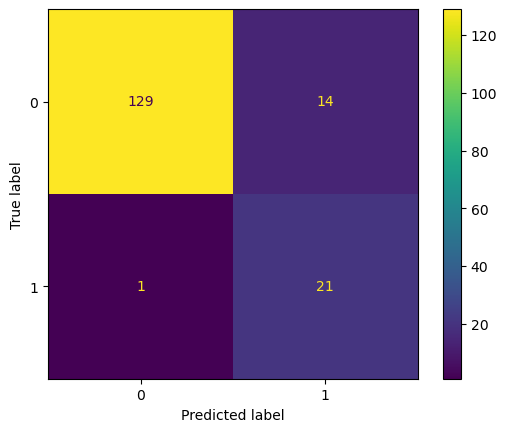

In [43]:
# Generating a confusion matrix and displaying it
cm = confusion_matrix(y_test, grid_search_y_pred)
# Creating a ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(cm, display_labels = solver_grid_search_model.classes_)
# Plotting the confusion matrix
disp.plot()
plt.show()

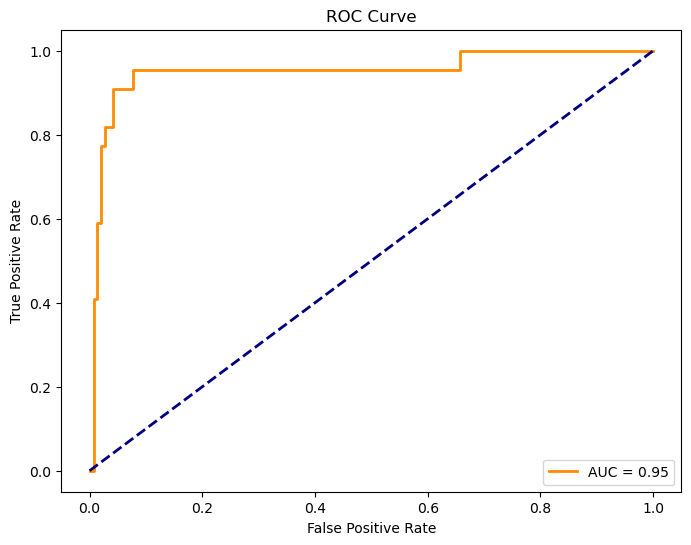

AUC-ROC score: 0.95


In [44]:
# Predicting probabilities for the positive class using the Logistic Regression model with L2 penalty
l2_y_probs = solver_grid_search_model.predict_proba(X_test)[:, 1]

# Calculating AUC-ROC score
l2_roc_auc = roc_auc_score(y_test, l2_y_probs)

# Calculating ROC curve
fpr, tpr, thresholds = roc_curve(y_test, l2_y_probs)

# Plotting ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {l2_roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Displaying the AUC-ROC score
print(f'AUC-ROC score: {l2_roc_auc:.2f}')

### Model 3: Logistic Regression with Lbfgs Solver and L2 Penalty (Resampled)

In [45]:
# Instantiating a Logistic Regression model with L2 penalty and balanced class weights
l2_logreg_resampled = LogisticRegression(
    random_state=42,            # Setting a random seed for reproducibility
    max_iter=10000,              # Maximum number of iterations for convergence
    solver='lbfgs',             # Specifying the solver for logistic regression
    penalty='l2',                # L2 penalty for regularization
    class_weight='balanced'      # Balancing class weights to handle imbalanced data
)
# Displaying class distribution before oversampling
print("Class distribution before oversampling:")
print(np.bincount(y_train))

# Oversampling the minority class using the resample function
X_resampled, y_resampled = resample(
    X_train.loc[y_train == 1],  # Selecting minority class samples
    y_train[y_train == 1],       # Corresponding labels
    replace=True,                # Allowing replacement to oversample
    n_samples=X_train[y_train == 0].shape[0],  # Matching the number of majority class samples
    random_state=42              # Setting a random seed for reproducibility
)

# Combining the oversampled minority class with the majority class
X_resampled = pd.concat([X_train.loc[y_train == 0], pd.DataFrame(X_resampled, columns=X_train.columns)])
y_resampled = pd.concat([y_train[y_train == 0], pd.Series(y_resampled)])


# Displaying class distribution after oversampling
print("Class distribution after oversampling:")
print(np.bincount(y_resampled))

# Training the logistic regression model on the resampled data
l2_model_resampled = l2_logreg_resampled.fit(X_resampled, y_resampled)

# Making predictions on the test set
l2_y_pred_resampled = l2_model_resampled.predict(X_test)

# Displaying the classification report
print("Classification Report:")
pd.DataFrame(classification_report(y_test, l2_y_pred_resampled, output_dict = True))

Class distribution before oversampling:
[428  66]
Class distribution after oversampling:
[428 428]
Classification Report:


,0,1,accuracy,macro avg,weighted avg
precision,0.992366,0.617647,0.915152,0.805007,0.942404
recall,0.909091,0.954545,0.915152,0.931818,0.915152
f1-score,0.948905,0.750000,0.915152,0.849453,0.922384
support,143.000000,22.000000,0.915152,165.000000,165.000000


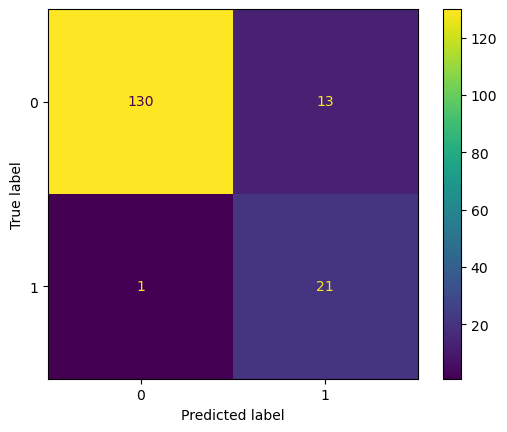

In [46]:
# Generating a confusion matrix for the resampled Logistic Regression model
cm = confusion_matrix(y_test, l2_y_pred_resampled)
# Creating a ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(cm, display_labels = l2_model_resampled.classes_)
# Plotting the confusion matrix
disp.plot()
plt.show()

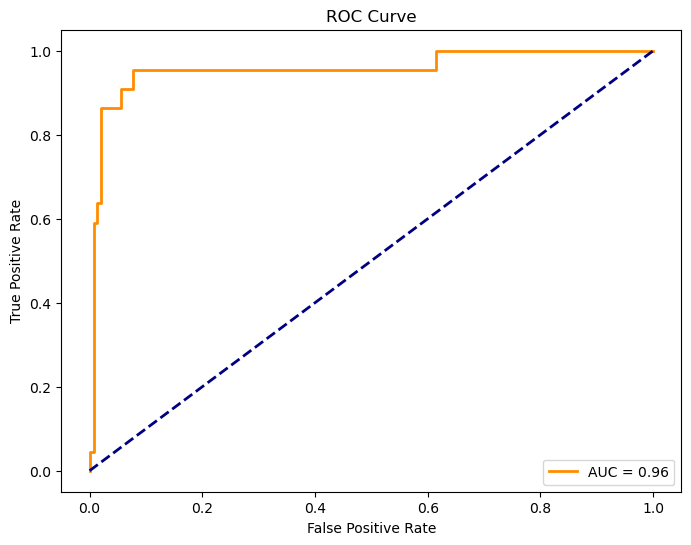

AUC-ROC score: 0.96


In [47]:
# Predicting probabilities for the positive class using the resampled Logistic Regression model
l2_y_probs_RS = l2_model_resampled.predict_proba(X_test)[:, 1]

# Calculating AUC-ROC score for the resampled model
l2_roc_auc_RS = roc_auc_score(y_test, l2_y_probs_RS)

# Calculating ROC curve for the resampled model
fpr, tpr, thresholds = roc_curve(y_test, l2_y_probs_RS)

# Plotting ROC curve for the resampled model
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {l2_roc_auc_RS:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Displaying the AUC-ROC score for the resampled model
print(f'AUC-ROC score: {l2_roc_auc_RS:.2f}')

# Validation
### Model 3: Logistic Regression with Lbfgs Solver and L2 Penalty (Resampled)

In [48]:
# Making predictions on the validation set using the resampled Logistic Regression model
y_pred_val = l2_model_resampled.predict(X_val)

# Evaluating the model on the validation set and creating a classification report
print("Classification Report:")
clf_report = classification_report(y_val, y_pred_val, output_dict = True, zero_division = 0)
pd.DataFrame(clf_report)

Classification Report:


,0,1,accuracy,macro avg,weighted avg
precision,0.992248,0.555556,0.89697,0.773902,0.936669
recall,0.888889,0.952381,0.89697,0.920635,0.896970
f1-score,0.937729,0.701754,0.89697,0.819742,0.907696
support,144.000000,21.000000,0.89697,165.000000,165.000000


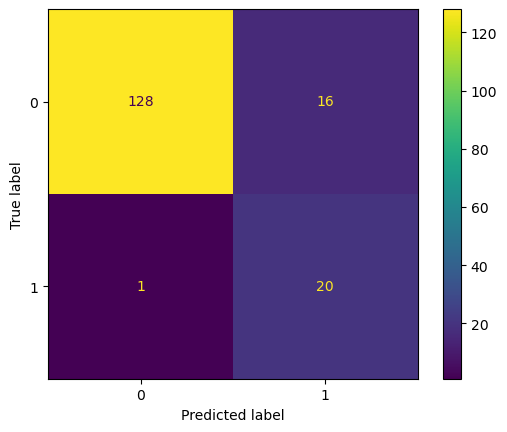

In [49]:
# Generating a confusion matrix and displaying it for the resampled Logistic Regression model on the validation set
cm = confusion_matrix(y_val, y_pred_val)
# Creating a ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(cm, display_labels = l2_model_resampled.classes_)
# Plotting the confusion matrix
disp.plot()
plt.show()

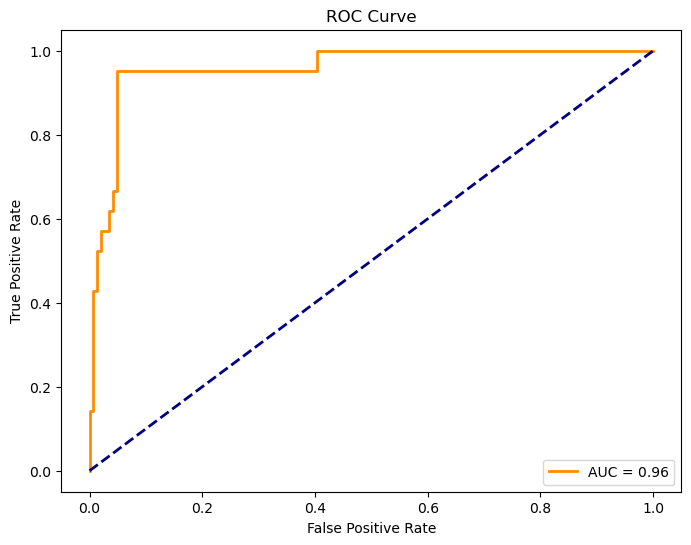

AUC-ROC score: 0.96


In [50]:
# Predicting probabilities for the positive class using the resampled Logistic Regression model on the validation set
y_probs_val = l2_model_resampled.predict_proba(X_val)[:, 1]

# Calculating AUC-ROC score for the resampled model on the validation set
roc_auc_val = roc_auc_score(y_val, y_probs_val)

# Calculating ROC curve for the resampled model on the validation set
fpr, tpr, thresholds = roc_curve(y_val, y_probs_val)

# Plotting ROC curve for the resampled model on the validation set
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc_val:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Displaying the AUC-ROC score for the resampled model on the validation set
print(f'AUC-ROC score: {roc_auc_val:.2f}')

In [51]:
# Setting the desired confidence leve
confidence = 0.95

# Calculating the Z-value corresponding to the confidence level
z_value = stats.norm.ppf((1 + confidence) / 2.0)

In [52]:
# Calculating recall on the test set using the resampled Logistic Regression model
recall_val = recall_score(y_val, l2_model_resampled.predict(X_val))  # Assuming you are using binary classification
# Calculating the confidence interval length
ci_length = z_value * np.sqrt((recall_val * (1 - recall_val)) / y_val.shape[0])

# Calculating the lower and upper bounds of the confidence interval
ci_lower, ci_upper = recall_val - ci_length, recall_val + ci_length

# Displaying recall and confidence interval
print(f"Recall: {recall_val:.4f}")
print(f"{confidence*100:.0f}% CI [{ci_lower:.2f}, {ci_upper:.2f}]")

Recall: 0.9524
95% CI [0.92, 0.98]


In [53]:
# Calculating accuracy on the test set using the resampled Logistic Regression model
acc_val = l2_model_resampled.score(X_val, y_val)

# Calculating the confidence interval length
ci_length = z_value * np.sqrt((acc_val * (1 - acc_val)) / y_val.shape[0])

# Calculating the lower and upper bounds of the confidence interval
ci_lower, ci_upper = acc_val - ci_length, acc_val + ci_length

# Displaying accuracy and confidence interval
print(f"Accuracy: {acc_val:.4f}")
print(f"{confidence*100:.0f}% CI [{ci_lower:.2f}, {ci_upper:.2f}]")

Accuracy: 0.8970
95% CI [0.85, 0.94]


In [54]:
# Calculating precision on the test set using the resampled Logistic Regression model
precision_val = precision_score(y_val, l2_model_resampled.predict(X_val))  # Assuming you are using binary classification

# Calculating the confidence interval length
ci_length = z_value * np.sqrt((precision_val * (1 - precision_val)) / y_val.shape[0])

# Calculating the lower and upper bounds of the confidence interval
ci_lower, ci_upper = precision_val - ci_length, precision_val + ci_length

# Displaying precision and confidence interval
print(f"Precision: {precision_val:.4f}")
print(f"{confidence*100:.0f}% CI [{ci_lower:.2f}, {ci_upper:.2f}]")

Precision: 0.5556
95% CI [0.48, 0.63]


In [55]:
# Calculating F1-score on the test set using the resampled Logistic Regression model
f1_score_val = f1_score(y_val, l2_model_resampled.predict(X_val)) # Assuming you are using binary classification

# Calculating the confidence interval length
ci_length = z_value * np.sqrt((f1_score_val * (1 - f1_score_val)) / y_val.shape[0])

# Calculating the lower and upper bounds of the confidence interval
ci_lower, ci_upper = f1_score_val - ci_length, f1_score_val + ci_length

# Displaying F1-score and confidence interval
print(f"F1-score: {f1_score_val:.4f}")
print(f"{confidence*100:.0f}% CI [{ci_lower:.2f}, {ci_upper:.2f}]")

F1-score: 0.7018
95% CI [0.63, 0.77]


In [56]:
# Calculating AUC-ROC score on the test set using the resampled Logistic Regression model
roc_auc_val = roc_auc_score(y_val, l2_model_resampled.predict_proba(X_val)[:, 1])  # Assuming you are using binary classification

# Calculating the confidence interval length
ci_length = z_value * np.sqrt((roc_auc_val * (1 - roc_auc_val)) / y_val.shape[0])

# Calculating the lower and upper bounds of the confidence interval
ci_lower, ci_upper = roc_auc_val - ci_length, roc_auc_val + ci_length

# Displaying AUC-ROC score and confidence interval
print(f"AUC-ROC Score: {roc_auc_val:.4f}")
print(f"{confidence*100:.0f}% CI [{ci_lower:.2f}, {ci_upper:.2f}]")

AUC-ROC Score: 0.9590
95% CI [0.93, 0.99]


## Report


**Model 1: Logistic Regression with Saga Solver and Elastic Net Penalty**
I used GridSearchCV to determine the best L1 ratio based on recall scoring. I ran this model twice: first with a parameter grid ranging from 0.1 to 0.9 and then with a range of 0.01 to 0.09. The best model had an L1 penalty of 0.01, indicating that 99.99% of the penalty was L2 for optimal performance.

**Model 2: Logistic Regression with L2 Penalty**
Building on the results from the first model, I conducted another grid search using L2 as the sole penalty and searched for the best solver among "lbfgs," "liblinear," "newton-cg," "newton-cholesky," "sag," and "saga." The results showed that the solver resulting in the highest recall score was lbfgs. Then when comparing Model 2 and Model 1's classification reports, there were significant differences in precision, F1 score, and accuracy, while the recall score remained the same at 95%.

**Model 3: Logistic Regression with Lbfgs Solver and L2 Penalty (Resampled)**
For this model, I aimed to further enhance performance by resampling the data in addition to having balanced class weights to mitigate the negative effects of unequal class distribution on logistic regression. After evaluating the metrics for the third model, I selected it as my preferred model. It demonstrated superior performance on the test data compared to the previous models in —precision, F1 score, and accuracy—with a slight decrease in recall by 0.0001%.

**Training Performance (Model 3 test results):**
- Confusion Matrix:
  - True Positive: 130
  - False Positive: 13
  - False Negative: 1
  - True Negative: 21


- Accuracy: 0.9152
- Precision: 0.6176
- Recall (Sensitivity or True Positive Rate): 0.9524
- F1 Score: 0.7500
- Area Under the ROC Curve (AUC-ROC): 0.9568

**Validation Performance (Model 3 validation results):**
- Confusion Matrix:
  - True Positive: 128
  - False Positive: 16
  - False Negative: 1
  - True Negative: 20



- Accuracy: 0.8970
> On the validation set, my model maintains a strong accuracy of 89.70%, demonstrating its reliability on new, unseen data.

- Precision: 0.5556
> The precision on the validation set is slightly lower at 55.56%, suggesting there might be a few false positives. This is an area where some improvement could be considered.

- Recall (Sensitivity or True Positive Rate): 0.9524
> Similar to the training set, the model captures 95.24% of actual churn cases in the validation set.

- F1 Score: 0.7018
> The F1 score on the validation set is 70.18%, indicating a good balance between precision and recall.

- Area Under the ROC Curve (AUC-ROC): 0.9590
> The AUC-ROC remains high at 95.90%, showcasing the model's consistent ability to discriminate between churn and non-churn instances.